In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import itertools
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_csv('Binance_BTCUSDT_1min.csv')
df = df.iloc[:,:6]
df.columns=['timestamp','open', 'high', 'low', 'close', 'volume']
df.reset_index(drop=True, inplace=True)
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [3]:
def resample_df(df, freq):
    resampled_open = df.open.resample(freq).first()
    resampled_high = df.high.resample(freq).max()
    resampled_low = df.low.resample(freq).min()
    resampled_close = df.close.resample(freq).last()
    resampled_volume = df.volume.resample(freq).sum()
    new_df = pd.concat([resampled_open, resampled_high, resampled_low, resampled_close, resampled_volume], axis=1)
    new_df.dropna(inplace=True)
    return new_df

In [4]:
def calc_price(new_df):
    new_df['price'] = new_df.open.shift(-1)

In [5]:
def calc_vol(new_df, vol_period):
    new_df['vol_ma'] = new_df.volume.rolling(vol_period).mean()
    new_df['vol_ratio'] = new_df.volume / new_df.vol_ma

In [17]:
"""def calc_vwap_result(new_df):
    dev_bands = [1]
    vwap_result = ta.vwap(high=new_df.high, low=new_df.low, close=new_df.close, volume=new_df.volume, anchor="W", bands=dev_bands)
    return vwap_result
    
    vwap_df = calc_vwap(new_df)
    merged_df = new_df.merge(vwap_df, how='left', left_index=True, right_index=True)"""

'def calc_vwap_result(new_df):\n    dev_bands = [1]\n    vwap_result = ta.vwap(high=new_df.high, low=new_df.low, close=new_df.close, volume=new_df.volume, anchor="W", bands=dev_bands)\n    return vwap_result\n    \n    vwap_df = calc_vwap(new_df)\n    merged_df = new_df.merge(vwap_df, how=\'left\', left_index=True, right_index=True)'

In [7]:
def calc_vwap(new_df):
    dev_bands = [1]
    vwap_result = ta.vwap(high=new_df.high, low=new_df.low, close=new_df.close, volume=new_df.volume, anchor="W", bands=dev_bands)
    new_df = new_df.merge(vwap_result, how='left', left_index=True, right_index=True)
    return new_df

In [8]:
def add_outside_band_status(new_df):
    above_upper_band = new_df['close'] > new_df['VWAP_W_U_1']
    inside_bands = (new_df['close'] < new_df['VWAP_W_U_1']) & (new_df['close'] < new_df['VWAP_W_L_1'])
    below_lower_band = new_df['close'] < new_df['VWAP_W_L_1']

    new_df['dev_status'] = 0
    
    new_df.loc[above_upper_band, 'dev_status'] = 1
    new_df.loc[inside_bands, 'dev_status'] = 0
    new_df.loc[below_lower_band, 'dev_status'] = -1

In [9]:
def is_trading_through(new_df):
    is_trading_through = (new_df['VWAP_W'] > new_df['low']) & (new_df['VWAP_W'] < new_df['high'])
    new_df['is_trading_through_status'] = False
    new_df.loc[is_trading_through, 'is_trading_through_status'] = True

In [81]:
def is_consolidate_absorb(new_df, lookback):
    # Calculate the rolling sum of the 'is_trading_through_status' column
    rolling_sum = new_df['is_trading_through_status'].rolling(window=lookback).sum()
    
    # Assign the rolling sum to the new column 'consolidate_absorb_value'
    new_df['consolidate_absorb_value'] = rolling_sum.fillna(0)  # Fill NaN values with 0
    
    return new_df

In [148]:
def calc_signals(new_df):
    new_df['signal'] = np.where((new_df.index.dayofweek != 0) & (new_df['consolidate_absorb_value'] > 4), True, False)
    new_df['signal_2'] = np.where((new_df.index.dayofweek != 0) & (new_df['vol_ratio'] > 4), True, False)
    new_df["signal_3"] = np.where(((new_df.index.dayofweek != 0) & (new_df['is_trading_through_status']) & (new_df['vol_ratio'] > 3)), True, False)
    new_df["signal_4"] = np.where(((new_df.index.dayofweek != 0) & (new_df['dev_status']  != 0)), True, False)
    new_df["signal_5"] = np.where(((new_df.index.dayofweek != 0) & (new_df['signal_4'] == True) & (new_df['vol_ratio'] > 3)), True, False)

In [136]:
new_df

,open,high,low,close,volume,vol_ma,vol_ratio,VWAP_W,VWAP_W_L_1,VWAP_W_U_1,dev_status,is_trading_through_status,consolidate_absorb_value,signal,signal_2,signal_3,signal_4
timestamp,,,,,,,,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,NaN,NaN,4294.590000,4294.590000,4294.590000,1,True,0.0,False,False,False,True
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,NaN,NaN,4300.266528,4293.645217,4306.887840,1,True,0.0,False,False,False,True
2017-08-17 06:00:00,4315.32,4345.45,4309.37,4324.35,7.229691,NaN,NaN,4302.698921,4293.106217,4312.291625,1,False,0.0,False,False,False,True
2017-08-17 07:00:00,4324.35,4349.99,4287.41,4349.99,4.443249,NaN,NaN,4304.129564,4293.135478,4315.123650,1,True,0.0,False,False,False,True
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,NaN,NaN,4304.752133,4292.432327,4317.071939,1,False,0.0,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-20 14:00:00,63875.53,63984.79,63746.00,63935.33,491.918590,1444.722144,0.340494,63162.760780,61718.601801,64606.919759,0,False,0.0,False,False,False,False
2024-04-20 15:00:00,63935.33,64960.37,63790.00,64808.35,1851.287500,1446.684718,1.279676,63171.593501,61728.039916,64615.147085,1,False,0.0,False,False,False,True
2024-04-20 16:00:00,64808.35,64969.39,64456.54,64739.24,1476.565950,1423.746096,1.037099,63179.600551,61735.520530,64623.680573,1,False,0.0,False,False,False,True


In [137]:
new_df = resample_df(df, "1H")
calc_vol(new_df, 30)
new_df = calc_vwap(new_df)
add_outside_band_status(new_df)
is_trading_through(new_df)
is_consolidate_absorb(new_df, 6)
calc_signals(new_df)
new_df

,open,high,low,close,volume,vol_ma,vol_ratio,VWAP_W,VWAP_W_L_1,VWAP_W_U_1,dev_status,is_trading_through_status,consolidate_absorb_value,signal,signal_2,signal_3,signal_4,signal_5
timestamp,,,,,,,,,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,NaN,NaN,4294.590000,4294.590000,4294.590000,1,True,0.0,False,False,False,True,False
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,NaN,NaN,4300.266528,4293.645217,4306.887840,1,True,0.0,False,False,False,True,False
2017-08-17 06:00:00,4315.32,4345.45,4309.37,4324.35,7.229691,NaN,NaN,4302.698921,4293.106217,4312.291625,1,False,0.0,False,False,False,True,False
2017-08-17 07:00:00,4324.35,4349.99,4287.41,4349.99,4.443249,NaN,NaN,4304.129564,4293.135478,4315.123650,1,True,0.0,False,False,False,True,False
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,NaN,NaN,4304.752133,4292.432327,4317.071939,1,False,0.0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-20 14:00:00,63875.53,63984.79,63746.00,63935.33,491.918590,1444.722144,0.340494,63162.760780,61718.601801,64606.919759,0,False,0.0,False,False,False,False,False
2024-04-20 15:00:00,63935.33,64960.37,63790.00,64808.35,1851.287500,1446.684718,1.279676,63171.593501,61728.039916,64615.147085,1,False,0.0,False,False,False,True,False
2024-04-20 16:00:00,64808.35,64969.39,64456.54,64739.24,1476.565950,1423.746096,1.037099,63179.600551,61735.520530,64623.680573,1,False,0.0,False,False,False,True,False


# Visualise

In [138]:
new_df = resample_df(df, "1H")
calc_vol(new_df, 30)
new_df = calc_vwap(new_df)
add_outside_band_status(new_df)
is_trading_through(new_df)
is_consolidate_absorb(new_df, 6)
calc_signals(new_df)
new_df.tail(10)

,open,high,low,close,volume,vol_ma,vol_ratio,VWAP_W,VWAP_W_L_1,VWAP_W_U_1,dev_status,is_trading_through_status,consolidate_absorb_value,signal,signal_2,signal_3,signal_4,signal_5
timestamp,,,,,,,,,,,,,,,,,,
2024-04-20 09:00:00,63729.44,63778.32,63277.00,63615.01,1137.53939,2007.528042,0.566637,63155.527643,61704.420022,64606.635264,0,False,0.0,False,False,False,False,False
2024-04-20 10:00:00,63615.00,63781.82,63377.22,63567.28,711.81603,1924.068182,0.369954,63156.595421,61707.180060,64606.010783,0,False,0.0,False,False,False,False,False
2024-04-20 11:00:00,63567.29,63924.05,63557.74,63707.17,718.98976,1880.331294,0.382374,63158.063542,61710.216922,64605.910163,0,False,0.0,False,False,False,False,False
2024-04-20 12:00:00,63707.18,63935.32,63575.83,63824.08,576.67455,1681.112671,0.343031,63159.335622,61712.702582,64605.968662,0,False,0.0,False,False,False,False,False
2024-04-20 13:00:00,63824.08,64047.92,63798.92,63875.53,813.92539,1558.224760,0.522341,63161.494611,61716.394751,64606.594472,0,False,0.0,False,False,False,False,False
2024-04-20 14:00:00,63875.53,63984.79,63746.00,63935.33,491.91859,1444.722144,0.340494,63162.760780,61718.601801,64606.919759,0,False,0.0,False,False,False,False,False
2024-04-20 15:00:00,63935.33,64960.37,63790.00,64808.35,1851.28750,1446.684718,1.279676,63171.593501,61728.039916,64615.147085,1,False,0.0,False,False,False,True,False
2024-04-20 16:00:00,64808.35,64969.39,64456.54,64739.24,1476.56595,1423.746096,1.037099,63179.600551,61735.520530,64623.680573,1,False,0.0,False,False,False,True,False
2024-04-20 17:00:00,64739.24,65419.00,64739.23,65200.00,2102.45135,1396.947194,1.505033,63193.763516,61745.587030,64641.940002,1,False,0.0,False,False,False,True,False


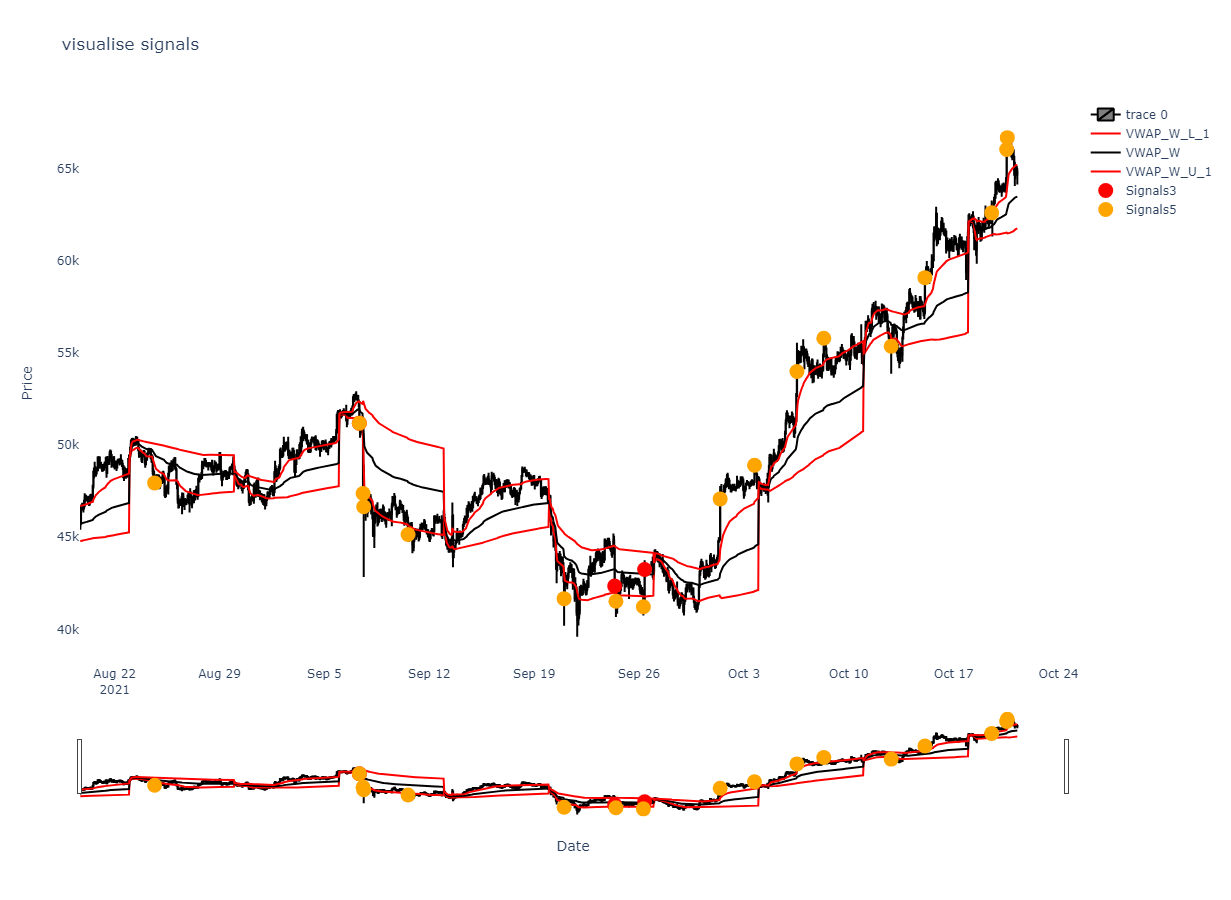

In [147]:
start_bar = 35000
end_bar = 36500
df_slice = new_df.iloc[start_bar:end_bar]
#cutoff_time = new_df.index[-(bars + 1)]
#trades_slice = trades[trades['entry_time'] >= cutoff_time]
#df_slice = new_df[new_df.index >= cutoff_time]

# Create a candlestick chart
fig = go.Figure(data=[go.Candlestick(x=df_slice.index,
                open=df_slice['open'],
                high=df_slice['high'],
                low=df_slice['low'],
                close=df_slice['close'], increasing_line_color='black', decreasing_line_color='black')])

# Add scatter plots for entry and exit points
#entry_points = dict(x=trades_slice['entry_time'], y=trades_slice['entry_price'], text=['Buy'] * len(trades_slice), mode='markers', name='Entry Points', marker=dict(color='darkgreen', size=15))
#avg_price = dict(x=trades_slice['entry_time'], y=trades_slice['avg_price'], text=['Avg'] * len(trades_slice), mode='markers', name='Avg Price', marker=dict(color='blue', size=7))
#exit_points = dict(x=trades_slice['exit_time'], y=trades_slice['exit_price'], text=['Sell'] * len(trades_slice), mode='markers', name='Exit Points', marker=dict(color='red', size=15))
signals_df = df_slice[df_slice['signal'] == True]
signals_df2 = df_slice[df_slice['signal_2'] == True]
signals_df3 = df_slice[df_slice['signal_3'] == True]
signals_df4 = df_slice[df_slice['signal_4'] == True]
signals_df5 = df_slice[df_slice['signal_5'] == True]


signals = dict(x=signals_df.index, y=signals_df['close'], text=['signal'] * len(signals_df), mode='markers', name='Signals', marker=dict(color='darkgreen', size=15))
signals2 = dict(x=signals_df2.index, y=signals_df2['close'], text=['signal_2'] * len(signals_df), mode='markers', name='Signals2', marker=dict(color='blue', size=15))
signals3 = dict(x=signals_df3.index, y=signals_df3['close'], text=['signal_3'] * len(signals_df), mode='markers', name='Signals3', marker=dict(color='red', size=15))
signals4 = dict(x=signals_df4.index, y=signals_df4['close'], text=['signal_4'] * len(signals_df), mode='markers', name='Signals4', marker=dict(color='purple', size=15))
signals5 = dict(x=signals_df5.index, y=signals_df5['close'], text=['signal_5'] * len(signals_df), mode='markers', name='Signals5', marker=dict(color='orange', size=15))

# Add entry and exit points to the figure
#fig.add_trace(go.Scatter(x=new_df.index, y=new_df['pdLow'], mode='lines', name='Previous Day Low'))
fig.add_trace(go.Scatter(x=df_slice.index, y=df_slice['VWAP_W_L_1'], mode='lines', name='VWAP_W_L_1', line=dict(color='red')))
fig.add_trace(go.Scatter(x=df_slice.index, y=df_slice['VWAP_W'], mode='lines', name='VWAP_W', line=dict(color='black')))
fig.add_trace(go.Scatter(x=df_slice.index, y=df_slice['VWAP_W_U_1'], mode='lines', name='VWAP_W_U_1', line=dict(color='red')))
#fig.add_trace(go.Scatter(x=new_df.index[-bars:], y=new_df['signal'][-bars:], mode='marker', name='signal', line=dict(color='red')))

#fig.add_trace(go.Scatter(signals))
#fig.add_trace(go.Scatter(signals2))
fig.add_trace(go.Scatter(signals3))
#fig.add_trace(go.Scatter(signals4))
fig.add_trace(go.Scatter(signals5))

#fig.add_trace(go.Scatter(avg_price))
#fig.add_trace(go.Scatter(exit_points))

# Update layout
fig.update_layout(title='visualise signals', xaxis_title='Date', yaxis_title='Price', width=1200, height=900, plot_bgcolor='white', yaxis=dict(showgrid=False), xaxis=dict(showgrid=False))

# Show the figure
fig.show()

In [47]:
signals_df = df_slice[df_slice['signal'] == True]

DatetimeIndex(['2024-04-08 07:00:00', '2024-04-08 08:00:00',
               '2024-04-08 09:00:00', '2024-04-08 10:00:00',
               '2024-04-08 11:00:00', '2024-04-08 12:00:00',
               '2024-04-08 13:00:00', '2024-04-08 14:00:00',
               '2024-04-08 15:00:00', '2024-04-08 16:00:00',
               ...
               '2024-04-20 09:00:00', '2024-04-20 10:00:00',
               '2024-04-20 11:00:00', '2024-04-20 12:00:00',
               '2024-04-20 13:00:00', '2024-04-20 14:00:00',
               '2024-04-20 15:00:00', '2024-04-20 16:00:00',
               '2024-04-20 17:00:00', '2024-04-20 18:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=300, freq=None)